# Preprocessing

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from os import listdir
from tensorflow import keras
import re
import pickle
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
labels = pd.read_csv('../data/original/train.csv')
labels_and_locations = []
total_labels = []
for label in labels['labels']:
    x = np.array(label.split(' ')).reshape(-1, 5)
    labels_and_locations.append(x)
    total_labels+= [xi[0] for xi in x]
labels['labels']=labels_and_locations

In [4]:
labels.head()

,image_id,labels
0,100241706_00004_2,"[[U+306F, 1231, 3465, 133, 53], [U+304C, 275, ..."
1,100241706_00005_1,"[[U+306F, 1087, 2018, 103, 65], [U+304B, 1456,..."
2,100241706_00005_2,"[[U+306F, 572, 1376, 125, 57], [U+306E, 1551, ..."
3,100241706_00006_1,"[[U+3082, 1455, 3009, 65, 44], [U+516B, 1654, ..."
4,100241706_00007_2,"[[U+309D, 1201, 2949, 27, 33], [U+309D, 1196, ..."


In [5]:
labels.loc[0, 'labels'][:10]

array([['U+306F', '1231', '3465', '133', '53'],
       ['U+304C', '275', '1652', '84', '69'],
       ['U+3044', '1495', '1218', '143', '69'],
       ['U+3051', '220', '3331', '53', '91'],
       ['U+306B', '911', '1452', '61', '92'],
       ['U+306B', '927', '3445', '71', '92'],
       ['U+306E', '904', '2879', '95', '92'],
       ['U+5DE5', '1168', '1396', '187', '95'],
       ['U+3053', '289', '3166', '69', '97'],
       ['U+4E09', '897', '3034', '121', '107']], dtype='<U6')

Each page ('image_id') comes with a -1x5 array, the first column of which is the unicode for a character, and the following 4 numbers are character location data: upper left x, upper left y, width, height. Next, I crop out each character.

In [6]:
train_filenames = listdir('../data/original/train_images/')

train_images = []
y = []
counter=0
for fp in train_filenames:
    if (counter%100==0):
        print(counter)
    counter+=1
    img = Image.open(f'../data/original/train_images/{fp}').convert(mode='L')
    for subimg in list(labels[labels['image_id']==fp[:-4]]['labels'])[0]:
        y.append(subimg[0])
        coords = list(subimg[1:])
        coords = tuple([int(coord) for coord in coords])
        coords = (coords[0], coords[1], coords[0]+coords[2], coords[1]+coords[3])
        train_images.append(img.crop(coords))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


In [7]:
len(y)

683464

In [8]:
len(train_images)

683464

In [9]:
train_df = pd.DataFrame([train_images, y]).T

In [10]:
train_df.columns=['img', 'char_unicode']

In [11]:
train_df.head()

,img,char_unicode
0,<PIL.Image.Image image mode=L size=105x17 at 0...,U+4E00
1,<PIL.Image.Image image mode=L size=33x18 at 0x...,U+30EC
2,<PIL.Image.Image image mode=L size=102x18 at 0...,U+4E00
3,<PIL.Image.Image image mode=L size=39x27 at 0x...,U+30EC
4,<PIL.Image.Image image mode=L size=33x28 at 0x...,U+30EC


In [12]:
# with open('../data/extracted_train/train_df.txt', 'wb') as fp:
#     pickle.dump(train_df, fp)

In [13]:
train_df['img'][1]

Next, loading the unicode-character conversion table

In [14]:
conversion = pd.read_csv('../data/original/unicode_translation.csv')
conversion.columns=['unicode', 'char']
conversion.head()

,unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9


In [15]:
train_df.columns = ['img', 'unicode']

In [16]:
train_df = train_df.set_index('unicode').join(conversion.set_index('unicode'))

In [17]:
train_df.head()

,img,char
unicode,,
U+003F,<PIL.Image.Image image mode=L size=118x149 at ...,?
U+2000B,<PIL.Image.Image image mode=L size=99x108 at 0...,𠀋
U+2000B,<PIL.Image.Image image mode=L size=96x113 at 0...,𠀋
U+2000B,<PIL.Image.Image image mode=L size=105x134 at ...,𠀋
U+2000B,<PIL.Image.Image image mode=L size=100x110 at ...,𠀋


勉


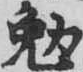

In [54]:
ind = 501010

print(train_df.reset_index()['char'][ind])
train_df.reset_index()['img'][ind]

In [19]:
# with open('../data/extracted_train/train_df.txt', 'wb') as fp:
#     pickle.dump(train_df, fp)

In [20]:
# total_labels = []
# for label in labels['labels']:
#     tokens = np.array(label.split(' ')).reshape(-1, 5)
#     chars = np.array([token[0] for token in tokens]).reshape(-1)
#     total_labels += list(chars)

Only a few hundred characters make up the large majority of those on the page. Most characters appear only in very trace amounts, with the rarest of them having only 1 img in train data. (See [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).)

In [21]:
counts = pd.DataFrame(pd.Series(y).value_counts(normalize=True))
counts.columns=['rel_freq']

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<Figure size 1440x576 with 0 Axes>

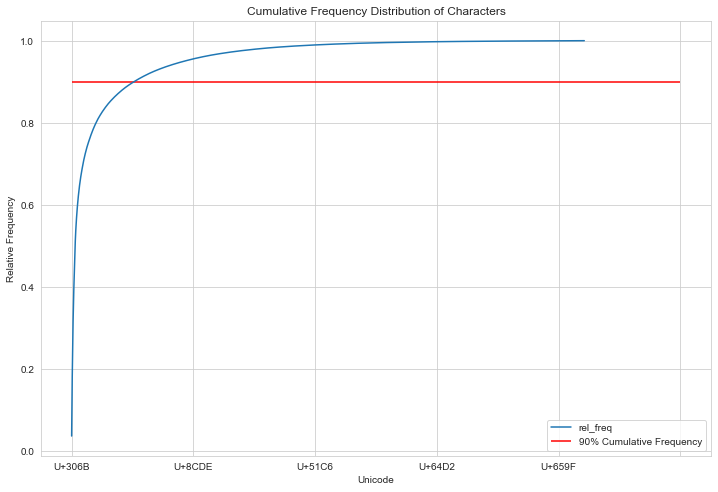

In [57]:
plt.figure(figsize=(20,8))
counts.sort_values('rel_freq', ascending=False).cumsum().plot(figsize=(12,8))
plt.hlines(0.9, xmin=0, xmax=5000, color='red', label='90% Cumulative Frequency')
plt.title('Cumulative Frequency Distribution of Characters')
plt.xlabel('Unicode')
plt.ylabel('Relative Frequency')
plt.legend()

In [23]:
len(counts[counts.cumsum()['rel_freq'] <= 0.9])

513

The rarest of those characters––1 to 20 images each––don't have enough data to train a model on. Because the model won't be able to recognize each of those rare characters, and to keep the number of classes at a few hundred rather than a few thousand, I'm keeping labels for only the most common characters (those that make up 90% of characters that appear on page, a total of 513 characters) and classifying all the others as 'rare' for a total of 514 classes.

In [24]:
top_513 = list(counts[counts.cumsum()['rel_freq'] <= 0.9].reset_index()['index'])

In [25]:
top_513

['U+306B',
 'U+306E',
 'U+3057',
 'U+3066',
 'U+3068',
 'U+3092',
 'U+306F',
 'U+304B',
 'U+308A',
 'U+306A',
 'U+3082',
 'U+3044',
 'U+308B',
 'U+3089',
 'U+305F',
 'U+304F',
 'U+3078',
 'U+307E',
 'U+304D',
 'U+308C',
 'U+3055',
 'U+3075',
 'U+3064',
 'U+3093',
 'U+304C',
 'U+3046',
 'U+3059',
 'U+3042',
 'U+3084',
 'U+304A',
 'U+3053',
 'U+3088',
 'U+3072',
 'U+3051',
 'U+3070',
 'U+305B',
 'U+305D',
 'U+309D',
 'U+3081',
 'U+3060',
 'U+4E00',
 'U+3067',
 'U+3069',
 'U+307F',
 'U+30A2',
 'U+306D',
 'U+4EBA',
 'U+3031',
 'U+308F',
 'U+3061',
 'U+30FB',
 'U+4E8B',
 'U+5165',
 'U+308D',
 'U+305A',
 'U+51FA',
 'U+3079',
 'U+4E91',
 'U+3058',
 'U+5B50',
 'U+53C8',
 'U+307B',
 'U+306C',
 'U+898B',
 'U+3086',
 'U+7269',
 'U+5927',
 'U+6B64',
 'U+3080',
 'U+4E0A',
 'U+65E5',
 'U+3054',
 'U+5176',
 'U+4E09',
 'U+3056',
 'U+65B9',
 'U+4E2D',
 'U+5C0F',
 'U+4E5F',
 'U+4F55',
 'U+25CB',
 'U+4E8C',
 'U+5973',
 'U+5019',
 'U+5FA1',
 'U+56FD',
 'U+5341',
 'U+3073',
 'U+4ECA',
 'U+30CF',
 'U+662F',

In [26]:
train_df.reset_index(inplace=True)

In [27]:
final_cat = [x if x in top_513 else 'rare' for x in train_df['unicode']]

In [28]:
pd.Series(final_cat).value_counts()

rare      68365
U+306B    24685
U+306E    24136
U+3057    22209
U+3066    20569
          ...  
U+30B7      126
U+6749      126
U+5B85      126
U+7E01      126
U+7686      126
Length: 514, dtype: int64

In [29]:
train_df['final_cat'] = final_cat

In [30]:
train_df.head()

,unicode,img,char,final_cat
0,U+003F,<PIL.Image.Image image mode=L size=118x149 at ...,?,rare
1,U+2000B,<PIL.Image.Image image mode=L size=99x108 at 0...,𠀋,rare
2,U+2000B,<PIL.Image.Image image mode=L size=96x113 at 0...,𠀋,rare
3,U+2000B,<PIL.Image.Image image mode=L size=105x134 at ...,𠀋,rare
4,U+2000B,<PIL.Image.Image image mode=L size=100x110 at ...,𠀋,rare


Lastly is the question of how to handle the variety of image sizes. Most of the images are roughly square-ish, but on the extreme end, some characters are nearly vertical stacks of pixels, and others are nearly horizontal lines. 

In [31]:
print(train_df['img'][100000].size)
train_df['img'][100000]

(16, 111)


In [32]:
print(train_df[train_df['char']=='一'].reset_index()['img'][0].size)
train_df[train_df['char']=='一'].reset_index()['img'][0]

(105, 17)


For baseline models, I resize all models to 80x80 pixels:

In [55]:
padding = []
for i, img in enumerate(train_df['img']):
    if i % 50000 == 0:
        print(i)
    desired_size = 80
    old_size = img.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    new_img = img.resize(new_size, Image.ANTIALIAS)
    padded_img = Image.new('L', (desired_size, desired_size))
    padded_img.paste(new_img, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
    padding.append(padded_img)

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000


迎


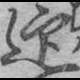

In [82]:
ind =660901
print(train_df['char'][ind])
padding[ind]

In [ ]:
# with open('../data/padding/X_padded_80.pkl', 'wb') as fp:
#     pickle.dump(padding, fp)

In [ ]:
# X = [np.asarray(img).astype('float32') for img in train_df['img']]

In [ ]:
# with open('../data/resize/X.pkl', 'wb') as fp:
#     pickle.dump(X, fp)

In [ ]:
# X_80 = np.array([np.array(img.resize((80,80))) for img in train_df['img']])
# y = np.array(train_df['final_cat'])

In [ ]:
# with open('../data/resize/X_80.pkl', 'wb') as fp:
#     pickle.dump(X_80, fp)

In [ ]:
# with open('../data/resize/y.pkl', 'wb') as fp:
#     pickle.dump(y, fp)